### T cell subset from annotated PICA dataset

### Load data into AnnData object

In [1]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import torch

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/01_preprocessing"


/Users/jessica/mambaforge/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata_cd4 = ad.read_h5ad('../../data/batch_integration_1-3_cd4_t_subset_batch1.h5ad')
adata_cd4

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_

In [3]:
sc.set_figure_params(dpi=50, facecolor="white")

In [4]:
adata_cd4.var_names_make_unique()
print(adata_cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2'

#### 1. Doublet detection
- doublets removed
- double check data filtered for doublets

In [28]:
dbl_rate = (adata_cd4.obs["status_manual"] == "doublet").mean()
print(f"Doublet rate: {dbl_rate:.2%}")

Doublet rate: 0.00%

In [6]:
for col in ["pica_id","pool_id","sequencing_batch"]:
    if col in adata_cd4.obs:
        print(f"\n{col} doublet fractions:")
        print(pd.crosstab(adata_cd4.obs[col], adata_cd4.obs["status_manual"], normalize="index").round(3))

pica_id doublet fractions:

status_manual  singlet
pica_id               
PICA0001           1.0
PICA0002           1.0
PICA0003           1.0
PICA0004           1.0
PICA0005           1.0
PICA0006           1.0
PICA0007           1.0

pool_id doublet fractions:

status_manual  singlet
pool_id               
Pool_1             1.0
Pool_2             1.0
Pool_3             1.0

sequencing_batch doublet fractions:

status_manual                               singlet
sequencing_batch                                   
20240530_WGS_20240530_sc_PICA0001-PICA0007      1.0

#### 2. QC
- QC metrics was calculated and Mt, Rb, Hb genes pre-defined
- check cells for quality
- low quality cells filtered 

### Visualize QC metrics

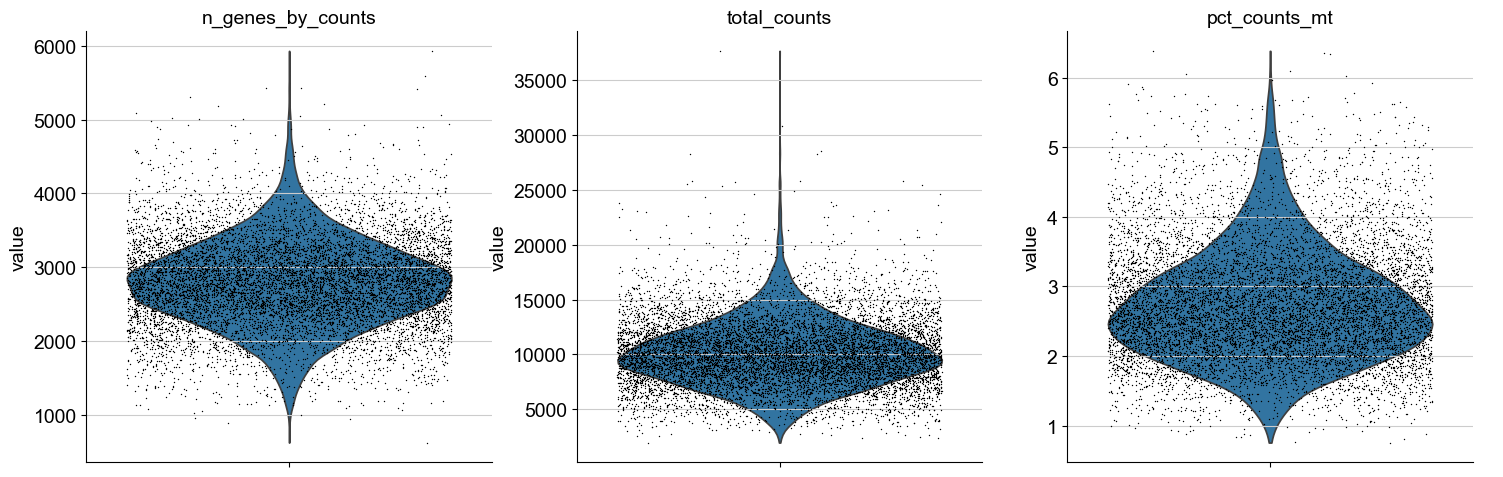

In [7]:
sc.pl.violin(adata_cd4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

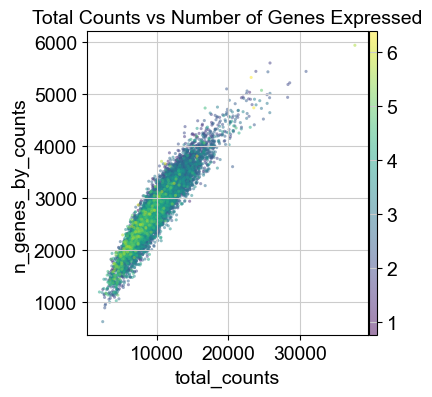

In [8]:
sc.pl.scatter(adata_cd4, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', title='Total Counts vs Number of Genes Expressed', alpha=0.5, size=20)

In [9]:
# save clean data
adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_clean.h5ad", compression='gzip')
adata_cd4

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_

#### 3. Preprocessing (post-QC)
a. Normalization \
b. HVGs (feature selection) \
c. PCA \
d. Neighbours/UMAP \
e. clustering 


In [10]:
adata_cd4 = sc.read_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_clean.h5ad")
adata_cd4

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_

##### 3a. Normalization

In [11]:
adata_cd4.layers['counts'] = adata_cd4.X.copy()  # Store raw counts in a separate layer
adata_cd4

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_

In [12]:
sc.pp.normalize_total(adata_cd4)  # default count to 1e4
sc.pp.log1p(adata_cd4)

#####  3b. Feature selection
Reduce dimensionality of dataset to only include informative genes

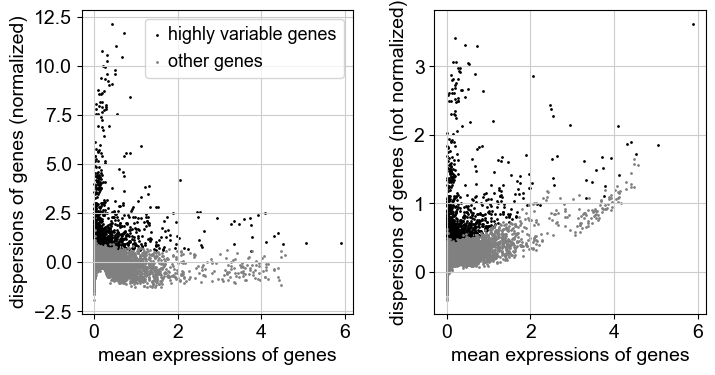

In [13]:
sc.pp.highly_variable_genes(adata_cd4, n_top_genes=2000, batch_key='pica_id')
sc.pl.highly_variable_genes(adata_cd4)

In [14]:
print(adata_cd4.var.highly_variable.sum())

2000

##### 3c. PCA(Dimensionality reduction)
How many PCs to consider to compute neighbourhood relation of cells
Used in clustering function leiden()

In [15]:
sc.tl.pca(adata_cd4)

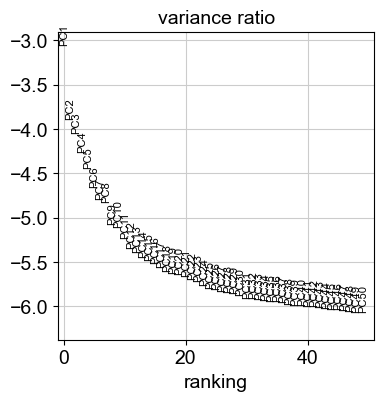

In [16]:
sc.pl.pca_variance_ratio(adata_cd4, n_pcs=50, log=True)

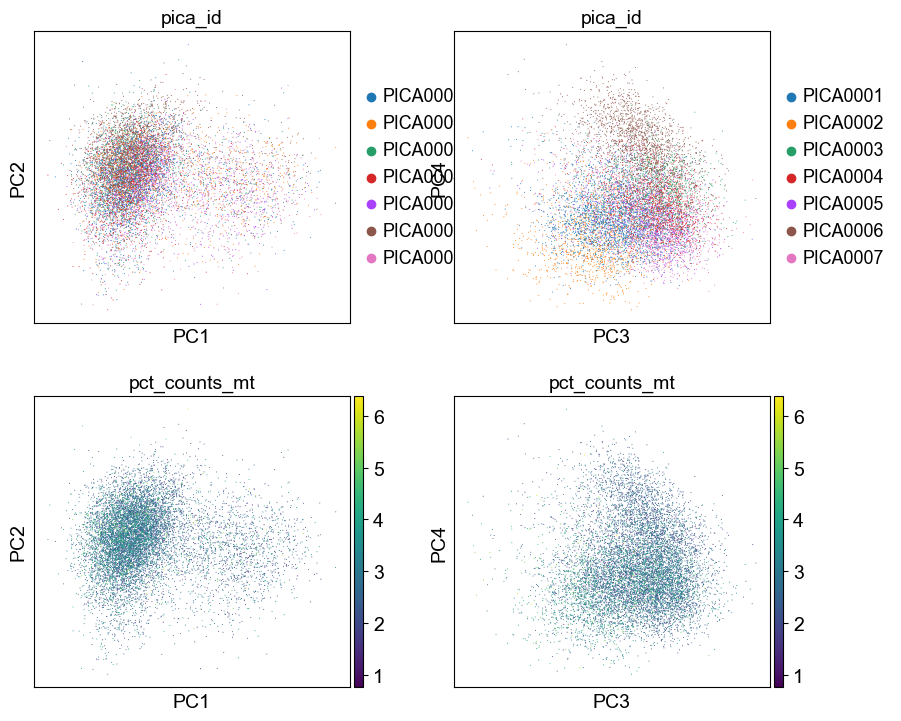

In [17]:
# Check PCA results for undesired technical artifacts like batch effects or mitochondrial stress
sc.pl.pca(
    adata_cd4,
    color=["pica_id", "pica_id", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

##### 3d. Neighbours/UMAP
Using PCA results

In [18]:
sc.pp.neighbors(adata_cd4)

In [19]:
sc.tl.umap(adata_cd4)

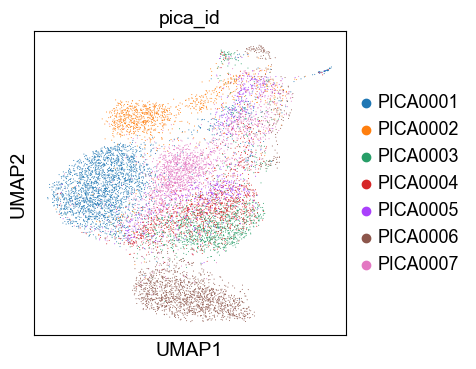

In [20]:
sc.pl.umap(
    adata_cd4,
    color="pica_id",
    size=2,
)

##### 3e. Clustering
Leiden graph- clustering method (community detection based on optimizing modularit) like in Seurat

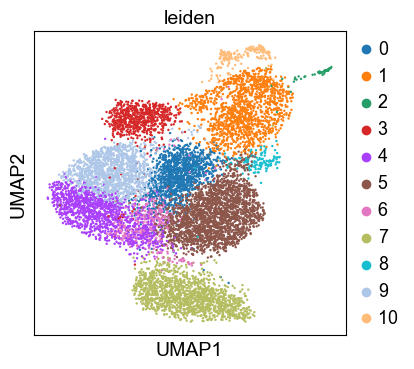

In [21]:
sc.tl.leiden(adata_cd4, flavor="igraph", n_iterations=2)
sc.pl.umap(adata_cd4, color=["leiden"])

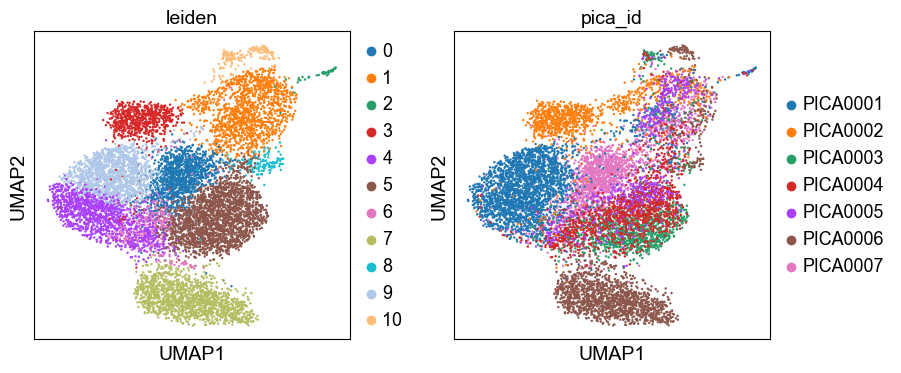

In [22]:
sc.pl.umap(adata_cd4, color = ['leiden','pica_id'], save="_prepocessed_leiden_pica_id_umap.png")

In [24]:
# save preprocessed adata
adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_preprocessed.h5ad", compression='gzip')
adata_cd4

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'l